# Part Two
## 1.Loading NSL_KDD DataSet

In [396]:
import pandas as pd # importig pandas to laod the file into data frame
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
columns = [ "duration","protocol_type","service","flag","src_bytes","dst_bytes",
"land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted",
"num_root","num_file_creations","num_shells","num_access_files",
"num_outbound_cmds","is_host_login","is_guest_login","count",
"srv_count","serror_rate","srv_serror_rate","rerror_rate",
"srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
"dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate",
"dst_host_srv_serror_rate","dst_host_rerror_rate",
"dst_host_srv_rerror_rate","label" ,"difficulty" ]

data = pd.read_csv('data.txt', header=None)
data.columns = columns

print(data.head()) # printing the first 5 rows of the data frame


   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2             

In [397]:
data.info() #displaying the data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [398]:
data['label'].value_counts() # displaying all the normal samples and attack samples counts

label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

## 1. Why do we set random seeds? What is reproducibility in machine learning?
- In machine learning, we set random seeds to ensure reproducibility, meaning the same code and data always produce the same results

## 2. How many samples are in the dataset?
- its 125973 from data.info()

## 3. How many features are present (excluding label and difficulty)?
- there are 41 total features(excluding label and difficulty) because from data.info() we get 43

## 4. What is the distribution between normal samples and attacks?
- Normal samples: 67,343 (53.4% of dataset)
- Attack samples: 58,630 (46.6% of dataset)
- Total: 125,973 samples
- This is a ~53:47 ratio, which is pretty good for machine learning (not heavily imbalanced)
## 5. Why is this distribution important for model training?

- This distribution is important because the model learns patterns from the data, so if the training data doesn’t represent the real-world distribution, the model won’t perform well on new data.

# Part 3

In [399]:
data.drop(['difficulty'], axis=1, inplace=True) # dropping the difficulty column as it is not needed

In [400]:
X_features = data.drop(['label'], axis=1) # features data frame without the label column
Y_labels = data['label'] # labels data frame with only the label column


In [401]:
X_features = pd.get_dummies(X_features, columns=['protocol_type', 'service', 'flag'])
# One-hot encoding for categorical features


In [402]:
Y_labels = data['label'].apply(lambda x: 0 if x == 'normal' else 1)
# converting labels to binary values: 0 for normal, 1 for attack

In [403]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features) # fit transform to scale the features

X_scaled = pd.DataFrame(X_scaled, columns=X_features.columns) # converting back to data frame

In [404]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_labels, test_size=0.2, random_state=42) 
# splitting the data into training and testing sets with 80% training and 20% testing



## 6. What encoding technique do you use for categorical variables? Why?
- we use One-Hot Encoding (via pd.get_dummies()) because Neural networks need numbers, not text while avoiding false numerical relationships between categories.

## 7. How many features do you have after encoding? Why did the number increase?

- we have 122 features because One-hot encoding replaces each categorical column with multiple binary columns (one per unique value). 

## 8. What type of classification problem is this (binary, multi-class, multi-label)?

- its a Binary Classification problem becasuse we encoded the labels as 0 (normal) or 1 (attack), creating only two possible classes.

## 9. Why is feature scaling important for neural networks?
- Without scaling, features with large values (e.g., src_bytes = 50,000) dominate the gradient updates over small-value features (e.g., serror_rate = 0.05), causing the model to ignore smaller features.

## 10. How many samples are in the training and testing sets?
- X_Train:100778
- X_Test: 25195
- Y_Train: 100778
- Y_Test:25195

# Part 4

In [405]:
# definition of the build function

def build_model(n_hidden_layers, n_neurons, learning_rate, dropout_rate):
    model = Sequential()
    model.add(Input(shape=(122,)))       
    for i in range(n_hidden_layers):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dropout(dropout_rate))# adding dropout layer to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # output layer for binary classification
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    #compiling the model with adam optimizer and binary crossentropy loss function that is suitable for binary classification and the adam optimizer is an efficient optimization algorithm that adapts the learning rate during training.
    return model


## 12. Why use sigmoid activation for the output layer?
- We use sigmoid activation for the output layer in binary classification because it squashes the output to a value between 0 and 1, which can be interpreted as the probability of the positive class.

## 13. What is the purpose of dropout layers?
- The purpose of dropout layers is to prevent overfitting in neural networks.

## 14. Compare the two architectures:


| Model           | Hidden Layers | Neurons per Layer | Trainable Parameters | Compression (Input → First Hidden) |
|-----------------|---------------|-----------------|--------------------|----------------------------------|
| Shallow Network | 1             | 4               | 497                | 122 → 4 ≈ 31                     |
| Deep Network    | 3             | 32              | 6071               | 122 → 32 ≈ 3.8                   |

## Notes
- **Trainable parameters calculation:**  
  - Dense layer: `(inputs × neurons) + neurons (biases)`  
  - Shallow hidden layer: (122×4) + 4 = 492  
  - Shallow output layer: (4×1) + 1 = 5 → Total = 492 + 5 = 497  
  - Deep first hidden: (122×32) + 32 = 3936  
  - Deep second hidden: (32×32) + 32 = 1056  
  - Deep third hidden: (32×32) + 32 = 1056  
  - Deep output: (32×1) + 1 = 33 → Total = 3936+1056+1056+33 = 6071  
- **Compression ratio:**  
  - Shallow: 122 input features → 4 neurons → 122 ÷ 4 ≈ 31  
    (high compression → lots of input info squeezed)  
  - Deep: 122 input features → 32 neurons → 122 ÷ 32 ≈ 3.8  
    (less compression → preserves more info for deeper layers)

## 15. Predict which model will perform better and explain why.

The deep network (Model 2) will likely perform better.

Why:

- It has more hidden layers and neurons, so it can learn more complex patterns in the data.

- Dropout prevents overfittin.

- Smaller learning rate and batch size allow stable and precise training.

# Part 5


In [406]:
# creating the models with the function we defined
shallow_model = build_model(n_hidden_layers=1, n_neurons=4, learning_rate=0.05, dropout_rate=0.0)
deep_model = build_model(n_hidden_layers=3, n_neurons=32, learning_rate=0.001, dropout_rate=0.2)

In [407]:
shallow_model.summary() # displaying the shallow model summary
deep_model.summary() # displaying the deep model summary

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 4)              │           492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 32)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,081 (23.75 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

In [408]:
history_shallow = shallow_model.fit(
    X_train,
    Y_train,
    epochs= 15,
    batch_size=512, 
    validation_split=0.2, # 20% percent of training data used for validation
)# defining the training process for the shallow model

history_deep = deep_model.fit(
    X_train,
    Y_train,
    epochs= 15,
    batch_size=64,
    validation_split=0.2, # 20% percent of training data used for validation
)# defining the training process for the deep model


Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9707 - loss: 0.0785 - val_accuracy: 0.9820 - val_loss: 0.0445
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0395 - val_accuracy: 0.9863 - val_loss: 0.0403
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0336 - val_accuracy: 0.9843 - val_loss: 0.0374
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9855 - loss: 0.0360 - val_accuracy: 0.9851 - val_loss: 0.0390
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0318 - val_accuracy: 0.9856 - val_loss: 0.0368
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0313 - val_accuracy: 0.9851 - val_loss: 0.0375
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9880 - loss: 0.0297 - val_accuracy: 0.9877 - val_loss: 0.0345
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0298 - val_accuracy: 0.

In [409]:
#testing for the shallow model
test_loss_shallow, test_acc_shallow = shallow_model.evaluate(X_test, Y_test, verbose=1)


788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9876 - loss: 0.0733


In [410]:
#testing for the deep model
test_loss_deep, test_acc_deep = deep_model.evaluate(X_test, Y_test, verbose=1)


788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9941 - loss: 0.0344


# 16. What does validation_split=0.2 mean?
- validation_split=0.2 means that 20% of your training data is set aside as a validation set while training.

# 17. Do you observe any differences in training stability between the two models? Why?
- yes the deep model perform way better than the shallow one ofc that is logical because it has less compression of data and more neurons to work with.
- for stability the deep model is way more stable on my testing i saw it in 99.49% to 99.50% accuracy unlike the shallow one it can go up from 97% to 98%.


# Part 6

In [411]:
print(f"Shallow Model - Test Loss: {test_loss_shallow:.4f}, Test Accuracy: {test_acc_shallow:.4f}")


print(f"Deep Model - Test Loss: {test_loss_deep:.4f}, Test Accuracy: {test_acc_deep:.4f}")

accuracy_diff = test_acc_deep - test_acc_shallow
print(f"Deep Model is {accuracy_diff:.4f} more accurate than Shallow Model")
 

Shallow Model - Test Loss: 0.0733, Test Accuracy: 0.9876
Deep Model - Test Loss: 0.0344, Test Accuracy: 0.9941
Deep Model is 0.0065 more accurate than Shallow Model


# 18. Which model performs better? By how much?
- of course its the deep model by approximatly 2% but that is a huge value for neural networks.

# 19. Is this result expected based on your prediction in Question 15?
- yes this result is to be expected due to the model having more neurons, less compression ratio, less batch sizes, more layers.

# 20. Explain why the shallow network underperforms:
- the shallow network underperforms because it has only one hidden layer, very few neurons (4) which compress the input too much and lose information, a high learning rate that can make training unstable, and no dropout, so overall it underfits and achieves lower accuracy.

# 21.Explain why the deep network performs better:

- The deep network performs better because it has multiple layers with 32 neurons each, allowing it to learn hierarchical and complex features, uses better hyperparameters like a lower learning rate and smaller batch size for stable training, and includes dropout for regularization, which helps it generalize and avoid overfitting.

# 22. Both models trained for the same number of epochs (15). Why does the deep network still perform better?

- The deep network performs better even with the same 15 epochs because it has higher capacity (more neurons and layers) to learn complex patterns, better hyperparameters (lower learning rate and smaller batch size) for stable updates, and dropout regularization to generalize well. The shallow network is too simple and underfits, so additional epochs wouldn’t help as much.

# Part 7

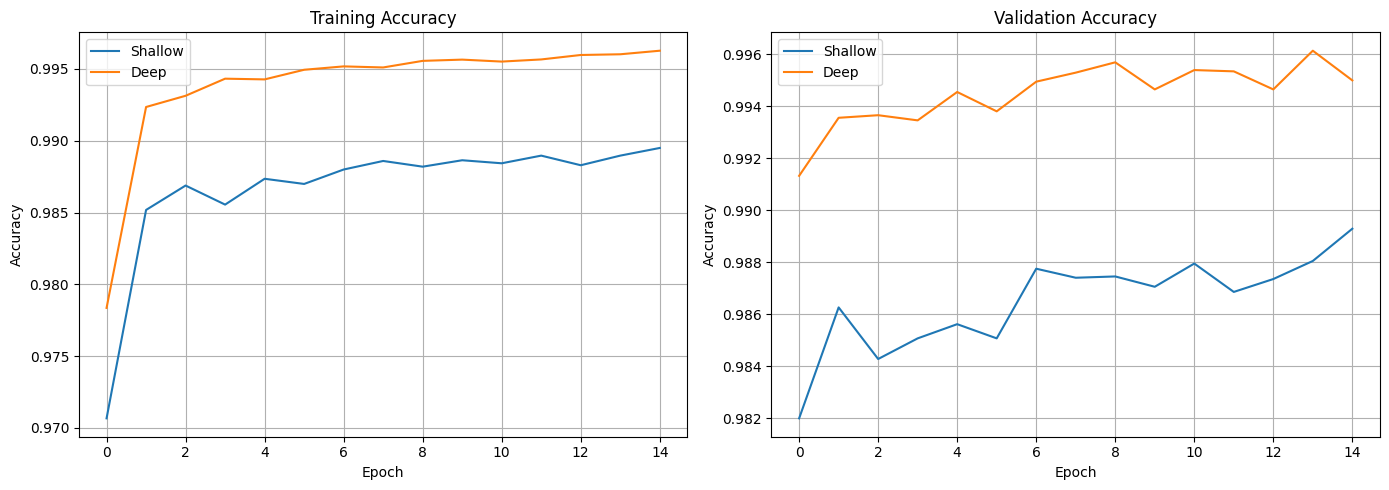

In [412]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 1️ Training Accuracy   
axs[0].plot(history_shallow.history['accuracy'], label='Shallow')
axs[0].plot(history_deep.history['accuracy'], label='Deep')
axs[0].set_title('Training Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# 2️ Validation Accuracy
axs[1].plot(history_shallow.history['val_accuracy'], label='Shallow')
axs[1].plot(history_deep.history['val_accuracy'], label='Deep')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

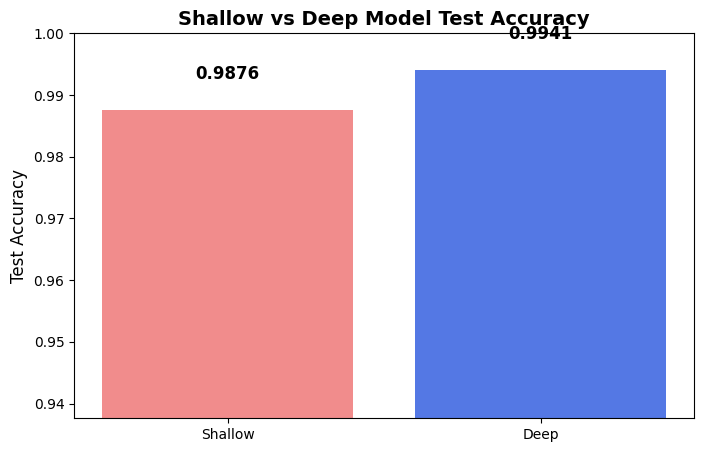

In [414]:
models = ['Shallow', 'Deep']
accuracies = [test_acc_shallow, test_acc_deep]

plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracies, color=['lightcoral','royalblue'], alpha=0.9)

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', fontsize=12, fontweight='bold')

# Emphasize the difference by adjusting y-axis
plt.ylim(min(accuracies) - 0.05, 1)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Shallow vs Deep Model Test Accuracy', fontsize=14, fontweight='bold')
plt.show()

# 23. What patterns do you observe in the training curves?
- The deep model consistently has higher accuracy than the shallow model at every epoch for both training and validation.

- The shallow model starts lower and improves slowly, showing that it struggles to learn complex patterns.

- The deep model not only reaches higher training accuracy but also maintains better validation accuracy, which means it generalizes better and doesn’t underfit like the shallow model.

# 24. Is there evidence of overfitting in either model?

- No, there is no evidence of overfitting in either model. The shallow model underfits, and the deep model generalizes well, with training and validation accuracies close or validation slightly higher due to dropout.

# 25. How would you present these results to non-technical stakeholders?
- The deep model is capable of calssifying the intruders better than the other one thus we will gain better secutiry to our product thus more money flowing.



# Part 8
## Experiment 1:


In [416]:
worse_shallow_network =build_model(n_hidden_layers=1, n_neurons=2, learning_rate=0.01, dropout_rate=0.0)

history_worse_shallow = worse_shallow_network.fit(
    X_train,
    Y_train,
    epochs= 15,
    batch_size=512,
    validation_split=0.2, # 20% percent of training data used for validation
)
test_loss_worse_shallow, test_acc_worse_shallow = worse_shallow_network.evaluate(X_test, Y_test, verbose=1)
print(f"Worse Shallow Model - Test Loss: {test_loss_worse_shallow:.4f}, Test Accuracy: {test_acc_worse_shallow:.4f}")

Epoch 1/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9383 - loss: 0.1813 - val_accuracy: 0.9653 - val_loss: 0.0986
Epoch 2/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9703 - loss: 0.0778 - val_accuracy: 0.9709 - val_loss: 0.0691
Epoch 3/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9763 - loss: 0.0608 - val_accuracy: 0.9776 - val_loss: 0.0602
Epoch 4/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.0553 - val_accuracy: 0.9793 - val_loss: 0.0572
Epoch 5/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9810 - loss: 0.0530 - val_accuracy: 0.9804 - val_loss: 0.0560
Epoch 6/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - loss: 0.0518 - val_accuracy: 0.9811 - val_loss: 0.0557
Epoch 7/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9818 - loss: 0.0511 - val_accuracy: 0.9808 - val_loss: 0.0543
Epoch 8/15
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9826 - loss: 0.0501 - val_accuracy: 0.

## Experiment 2


In [419]:
better_shallow_network = build_model(n_hidden_layers=1, n_neurons=64, learning_rate=0.001, dropout_rate=0.0)
history_better_shallow = better_shallow_network.fit(
    X_train,
    Y_train,
    epochs= 15,
    batch_size=64,
    validation_split=0.2, # 20% percent of training data used for validation
)
test_loss_better_shallow, test_acc_better_shallow = better_shallow_network.evaluate(X_test, Y_test)
print(f"Better Shallow Model - Test Loss: {test_loss_better_shallow:.4f}, Test Accuracy: {test_acc_better_shallow:.4f}")

Epoch 1/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9764 - loss: 0.0716 - val_accuracy: 0.9851 - val_loss: 0.0408
Epoch 2/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9902 - loss: 0.0304 - val_accuracy: 0.9908 - val_loss: 0.0285
Epoch 3/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9929 - loss: 0.0229 - val_accuracy: 0.9917 - val_loss: 0.0244
Epoch 4/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 0.9930 - val_loss: 0.0230
Epoch 5/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9938 - loss: 0.0186 - val_accuracy: 0.9934 - val_loss: 0.0201
Epoch 6/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9941 - loss: 0.0176 - val_accuracy: 0.9925 - val_loss: 0.0211
Epoch 7/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9949 - loss: 0.0163 - val_accuracy: 0.9944 - val_loss: 0.0190
Epoch 8/15
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9947 - loss: 0.0160 - 

# 27. Does it perform better now? How does it compare to the deep network?
- its much better then before , and its highly close to the deep learning they can be considered as really close models now.
# 28.What does this tell you about the importance of:
- Network capacity (number of neurons): Increasing the number of neurons in a layer allows the network to capture more information from the inputs, so even a single hidden layer with enough neurons can perform much better than multiple layers with very few neurons. This shows that capacity per layer often has a bigger impact than the number of hidden layers for simpler tasks.

- Hyperparameter tuning: Adjusting learning rate, batch size, and dropout can dramatically affect performance. Even a shallow network can improve a lot if these hyperparameters are chosen well, because training becomes more stable and efficient.


# Part 9
# In what scenarios might a shallow network be preferable despite lower accuracy?
- When you need very fast predictions
- When the dataset is very small
- When training time must be minimal
# What are the trade-offs between shallow and deep networks :
Shallow Networks:

- Training time: Much faster

- Inference speed: Much faster

- Memory requirements: Very low

- Interpretability: Easy to understand and explain

Deep Networks:

- Training time: Slower (more layers & parameters)

- Inference speed: Slower

- Memory requirements: High

- Interpretability: Hard to understand (black box)

# The deep network uses dropout. What would happen if we removed dropout? Would accuracy increase or decrease?

- removing this parameter would cause the model to overfit so it would decrease the models accuracy.